In [72]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
import shap
import joblib

In [73]:
# Set random seed for reproducibility
np.random.seed(42)

In [74]:
# A. Data Ingestion & Cleaning
# ----------------------------

In [75]:
# Define column names based on dataset description
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

In [76]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df = pd.read_csv(url, header=None, names=column_names, na_values='?', skipinitialspace=True)


In [77]:
# Clean the income column (target variable)
df['income'] = df['income'].str.strip()
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

In [78]:
# Handle missing values
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


In [79]:
# For categorical columns with missing values, we'll impute with mode
for col in ['workclass', 'occupation', 'native-country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


C:\Users\ckuck\AppData\Local\Temp\ipykernel_26348\2272501298.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [80]:

# B. Exploratory Data Analysis (EDA)
# ----------------------------------


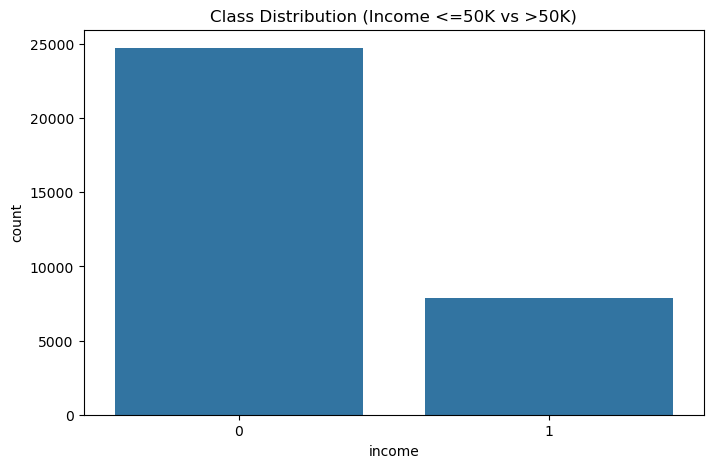

In [81]:

# Class imbalance analysis
plt.figure(figsize=(8, 5))
sns.countplot(x='income', data=df)
plt.title('Class Distribution (Income <=50K vs >50K)')
plt.show()

In [82]:

income_ratio = df['income'].value_counts(normalize=True)
print(f"\nClass ratio:\n{income_ratio}")



Class ratio:
income
0    0.75919
1    0.24081
Name: proportion, dtype: float64


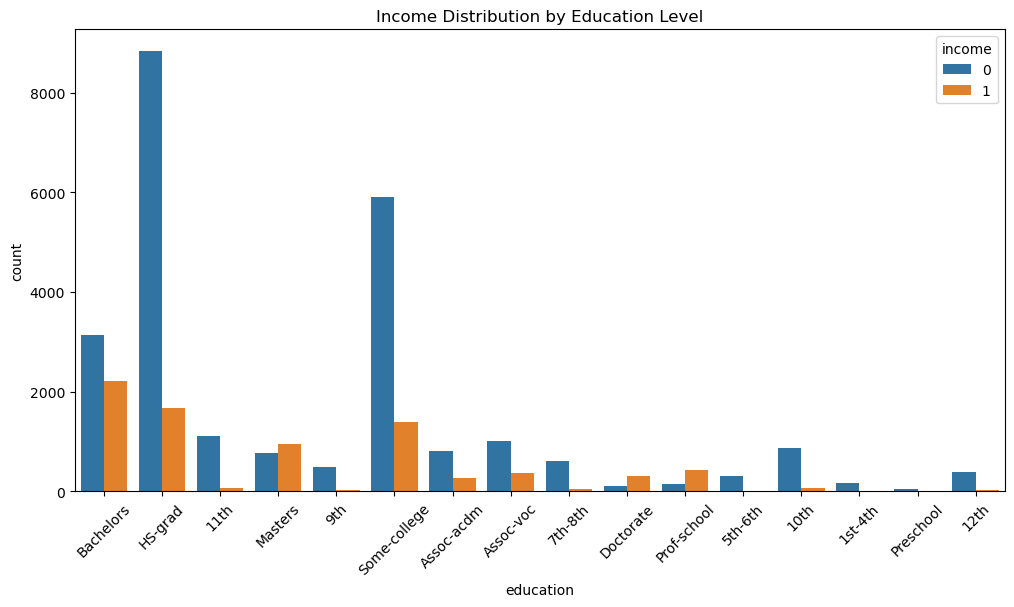

In [83]:
# Relationship between categorical features and target
plt.figure(figsize=(12, 6))
sns.countplot(x='education', hue='income', data=df)
plt.xticks(rotation=45)
plt.title('Income Distribution by Education Level')
plt.show()

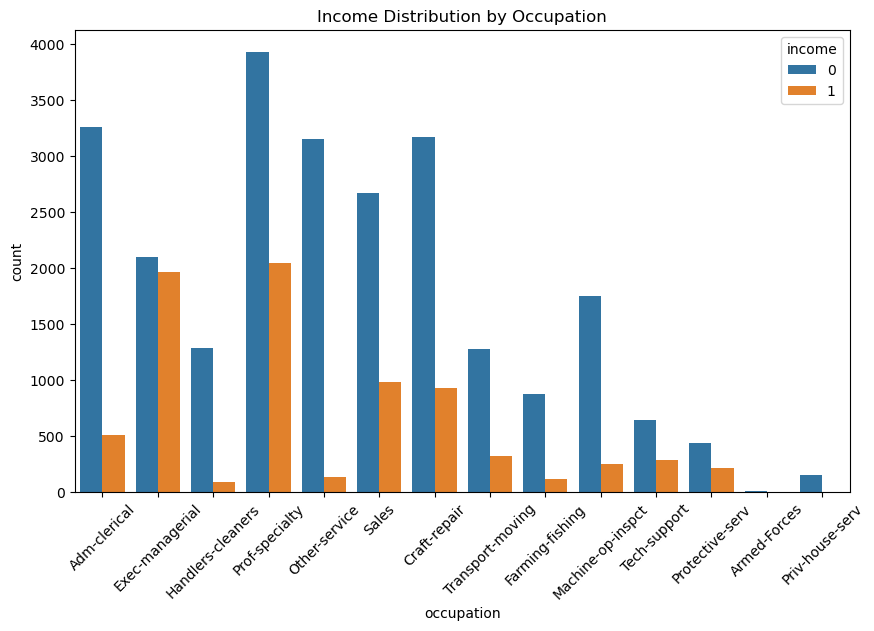

In [84]:
plt.figure(figsize=(10, 6))
sns.countplot(x='occupation', hue='income', data=df)
plt.xticks(rotation=45)
plt.title('Income Distribution by Occupation')
plt.show()

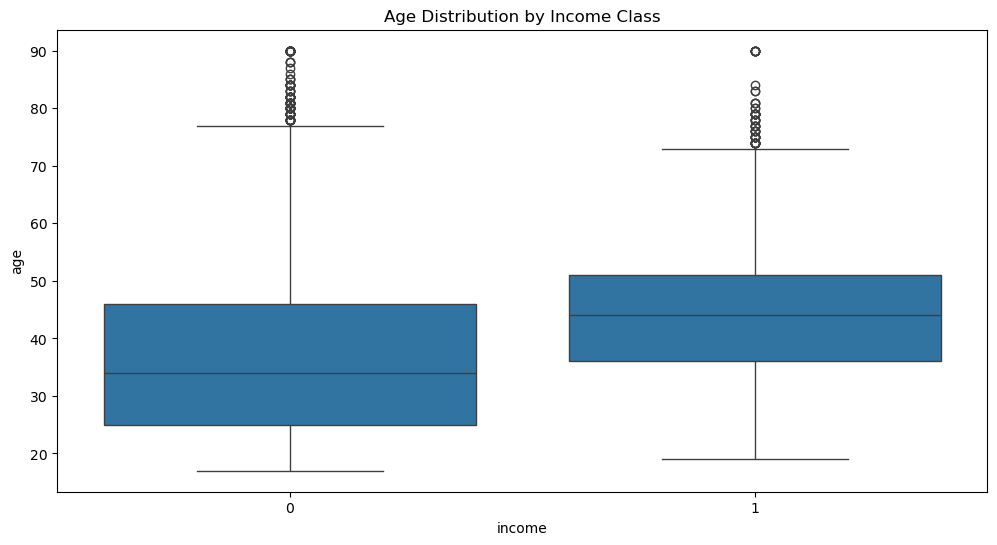

In [85]:
# Numerical features distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='income', y='age', data=df)
plt.title('Age Distribution by Income Class')
plt.show()

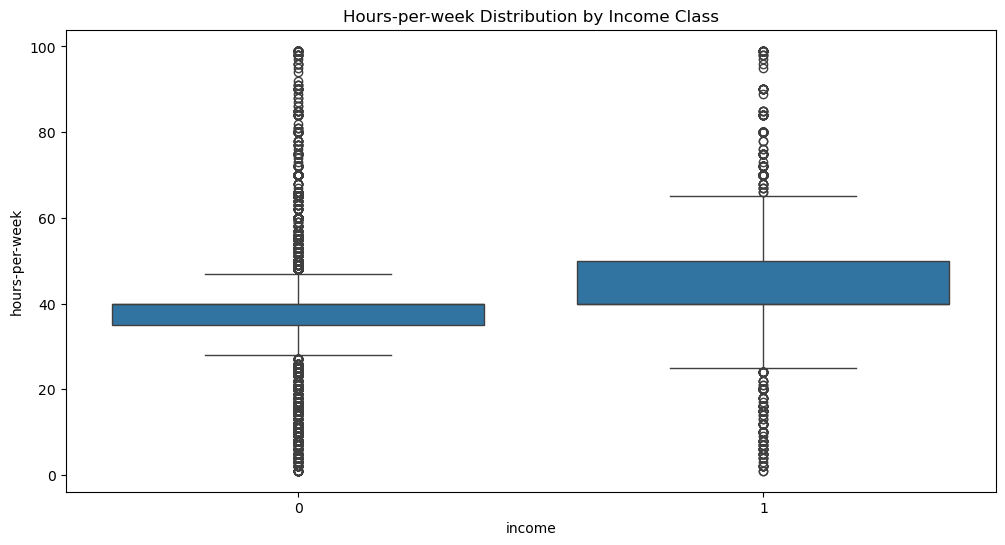

In [86]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='income', y='hours-per-week', data=df)
plt.title('Hours-per-week Distribution by Income Class')
plt.show()

In [87]:
# C. Feature Engineering & Preprocessing
# -------------------------------------


In [88]:
# Create new features
df['age_binned'] = pd.cut(df['age'], bins=[0, 25, 45, 65, 100], labels=['0-25', '25-45', '45-65', '65+'])
df['hours_education_interaction'] = df['hours-per-week'] * df['education-num']

In [89]:
# Separate features and target
X = df.drop('income', axis=1)
y = df['income']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define numerical and categorical features
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'hours_education_interaction']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'age_binned']


In [90]:
# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [91]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [92]:
# D. Model Training & Hyperparameter Tuning
# ----------------------------------------


In [93]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    # Generate predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    
    # Print classification report and metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'f1': f1,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Random Forest - Best Parameters:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Random Forest - Evaluation on Test Set:
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4945
           1       0.77      0.63      0.70      1568

    accuracy                           0.87      6513
   macro avg       0.83      0.79      0.81      6513
weighted avg       0.86      0.87      0.86      6513

Accuracy: 0.8669
ROC AUC: 0.9205
F1 Score: 0.6953


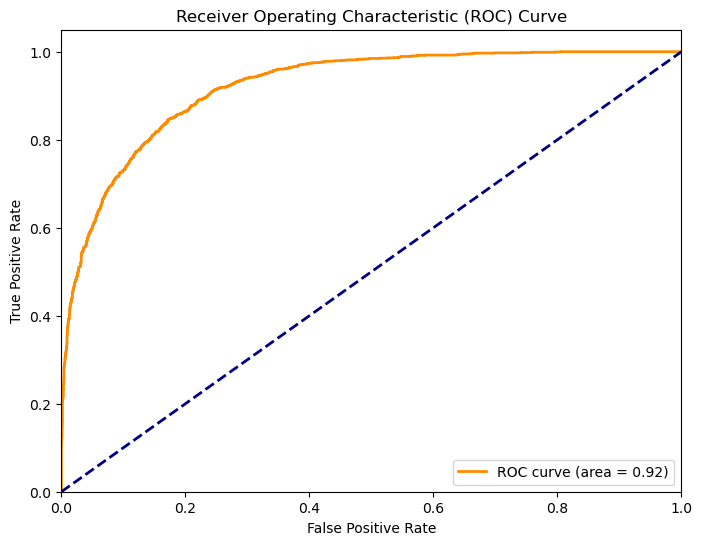

In [94]:
# Model 1: Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

print("\nRandom Forest - Best Parameters:")
print(rf_grid_search.best_params_)

print("\nRandom Forest - Evaluation on Test Set:")
rf_metrics = evaluate_model(rf_grid_search.best_estimator_, X_test, y_test)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\ckuck\.conda\envs\AI_ML_Project\lib\site-packages\xgboost\core.py:158: UserWarning: [16:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost - Best Parameters:
{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}

XGBoost - Evaluation on Test Set:
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4945
           1       0.78      0.67      0.72      1568

    accuracy                           0.88      6513
   macro avg       0.84      0.81      0.82      6513
weighted avg       0.87      0.88      0.87      6513

Accuracy: 0.8753
ROC AUC: 0.9311
F1 Score: 0.7219


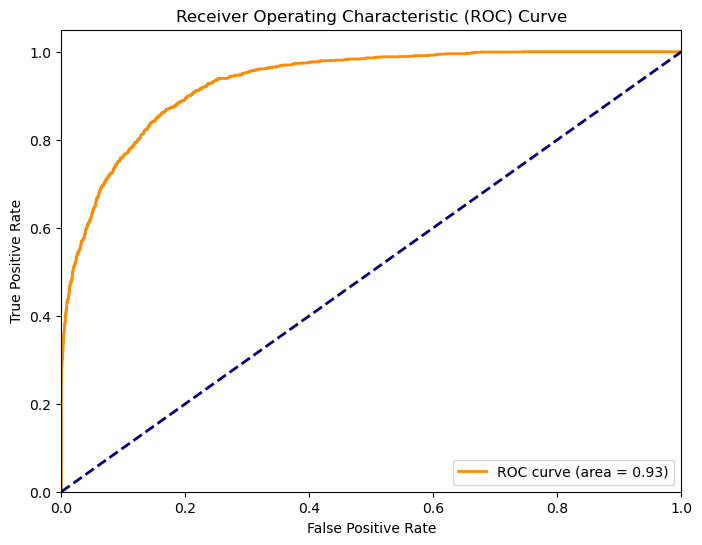

In [96]:
# First ensure XGBoost is imported with the correct alias
from xgboost import XGBClassifier, plot_importance  # Add plot_importance import

# Model 2: XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False))
])

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
xgb_grid_search.fit(X_train, y_train)

print("\nXGBoost - Best Parameters:")
print(xgb_grid_search.best_params_)

print("\nXGBoost - Evaluation on Test Set:")
xgb_metrics = evaluate_model(xgb_grid_search.best_estimator_, X_test, y_test)

# Feature Importance for XGBoost
best_xgb = xgb_grid_search.best_estimator_.named_steps['classifier']

# SHAP Analysis for XGBoost
X_processed =  xgb_grid_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()
X_sample = X_processed[:100]  # Use first 100 samples for SHAP


C:\Users\ckuck\AppData\Local\Temp\ipykernel_26348\3411391488.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, feature_names=all_features, plot_type='bar', show=False)


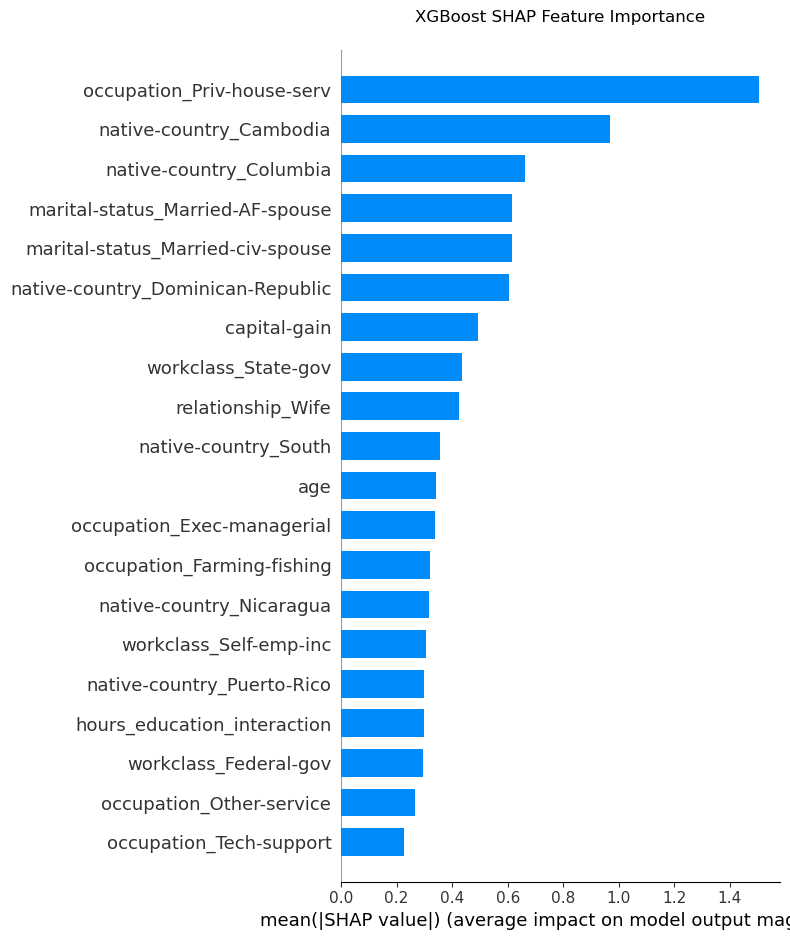

In [97]:
# E. Model Interpretation
# -----------------------
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_sample)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=all_features, plot_type='bar', show=False)
plt.title('XGBoost SHAP Feature Importance', pad=20)
plt.tight_layout()
plt.show()

In [98]:

# F. Pipeline Export (Optional Bonus)
# -----------------------------------

# Save the best model pipeline
best_model = rf_grid_search.best_estimator_
joblib.dump(best_model, 'income_prediction_pipeline.joblib')



['income_prediction_pipeline.joblib']

In [102]:
# Example of loading and using the pipeline
loaded_pipeline = joblib.load('income_prediction_pipeline.joblib')
new_sample = X_test.iloc[0:1]  # Take first row as example
prediction = loaded_pipeline.predict(new_sample)
prediction_proba = loaded_pipeline.predict_proba(new_sample)
print(f"Prediction: {prediction}, Probability: {prediction_proba}")

Prediction: [0], Probability: [[0.72616729 0.27383271]]
